# Mental Health in the Tech Industry Data Presentation and Visualization

Let's create a class for data presentation and visualization based on the Data_Processing module which gather and process the data form mental_health database.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from Data_Processing import DataProcessing as dp

In [2]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params)

In [115]:
class DataPresentation:
    ''' Class for data presentation and visualization for Mental Health in the Tech Industry Database.
        The DataProcessing class from Data_Processing module is used for gathering and processing the data'''
    
    def __init__(self, path, db_name):
        self.collector = dp(path, db_name)
    
    def show_answers_pct_for_questions(self, q_ids):
        '''  Show percentage of answers on given questions. '''
        for qid in q_ids:
            df = self.get_answers_pct(qid)
            print(df.name)
            print(df)
            print()
    
    def get_answers_pct(self, q_id):
        ''' Get percentage of answers on given question.
            Returns data frame answers*[answers [%], answers no]'''
        q_text = self.collector.get_question_text(q_id)
        df = pd.DataFrame(columns=['answers [%]', 'answers no'])
        df.name = f'Question {q_id}. {q_text}'
        for anspct, anssum in zip(self.collector.get_answers_distribution_for_q(q_id), self.collector.get_users_no_per_answer(q_id)):
            answer = self.change_zero_one_to_no_yes(anspct[0])
            df.loc[answer] = [anspct[1], anssum[1]]
        return df
    
    @staticmethod
    def change_zero_one_to_no_yes(answer):
        ''' Change zero or one to no or yes.
            That makes the data presentation more readable. '''
        if str(answer) == '0':
            return 'no'
        elif str(answer) == '1':
            return 'yes'
        else:
            return answer

    def show_answers_pct_yearly_for_questions(self, q_ids):
        '''  Show percentage of answers on given questions yearly. '''
        for qid in q_ids:
            df = self.get_answers_pct_yearly(qid)
            print(df.name)
            print(df)
            print()
        
    def get_answers_pct_yearly(self, q_id):
        ''' Get percentage of answers on given question yearly.
            Returns data frame answers*years'''
        q_text = self.collector.get_question_text(q_id)
        df = pd.DataFrame()
        df.name = f'Question {q_id}. {q_text} [%]'
        for answer, year, pct in self.collector.get_answers_distribution_for_q_by_years(q_id):
            answer = self.change_zero_one_to_no_yes(answer)
            df.loc[answer, year] = pct
        return df
    
    def show_answers_ratio_by_categories_for_questions(self, q_ids):
        ''' Show the ratio of the answers on one questions categorized by another questions.
            Each element of q_ids list should includes two question:
            first one determine the categories
            second one the actual question, e.g. [8, 7].'''
        for cat_q, pos_q in q_ids:
            df = self.get_answers_ratio_by_categories(cat_q, pos_q)
            cat_text = self.collector.get_question_text(cat_q)
            pos_text = self.collector.get_question_text(pos_q)
            print(f'Categories determined by question {cat_q}:')
            print(cat_text)
            print(f'Ratio for the following question {pos_q}:')
            print(pos_text)
            print(df)
            print()
        
        
    def get_answers_ratio_by_categories(self, q_cat, q_pos):
        ''' Get the ratio of answers on one question (q_pos) by categories from another question (q_cat).
            Returns the data frame categories*[answers [%], answers no]'''
        answers = [answer[0] for answer in self.collector.get_all_answers_per_q(q_pos)]
        columns = [self.change_zero_one_to_no_yes(answer)+' [%]' for answer in answers]
        tabs = []
        answers_no = []
        df = pd.DataFrame(columns=columns+['answers no'])
        for answer in answers:
            col = self.change_zero_one_to_no_yes(answer)+' [%]'
            tabs.append(self.collector.get_some_answer_no_based_on_answer_and_q(q_cat, q_pos, answer))
            for row in self.collector.get_some_answer_no_based_on_answer_and_q(q_cat, q_pos, answer):
                cat = self.change_zero_one_to_no_yes(row[0])
                try:
                    df.loc[cat, col] += row[1]
                except KeyError:
                    df.loc[cat] = 0
                    df.loc[cat, col] += row[1]
        df['answers no'] = df[columns].sum(axis=1)
        df[columns] = df[columns].divide(df['answers no'], axis=0)*100
        df[columns] = df[columns].apply(lambda x: round(x.astype('float'), 2), axis=1)
        return df
    
    def plot_answers_histogram(self, q_id):
        ''' Plot answers distribution for given question represented by histogram. Only quantitative answers are supported. '''
        answers = [int(answer[0]) for answer in self.collector.get_answers_for_question(q_id)]
        q_text = self.collector.get_question_text(q_id)
        plt.figure(figsize=(15, 8))
        plt.suptitle(q_text, size='x-large')
        plt.title('Answers distribution')
        sns.histplot(answers)
    
    def plot_answers_distribution(self, q_id):
        ''' Plot answers distribution for given question represented by bars. '''
        output = self.collector.get_users_no_per_answer(q_id)
        answers = [answer[0] for answer in  output]
        answers_no = [answer[1] for answer in output]
        q_text = self.collector.get_question_text(q_id)
        plt.figure(figsize=(15, 8))
        plt.suptitle(q_text, size='x-large')
        plt.title('Answers distribution')
        sns.barplot(x=answers, y=answers_no, palette="Blues_d")
        if len(answers) > 8:
            plt.xticks(rotation=45)
        self.addlabels(answers_no)
       
    @staticmethod
    def addlabels(values, pos='horizontal'):
        ''' Add labels with values in the bar-like chart.
            The values are the values to be shown on the chart.
            The pos is a horizontal (default) or vertical positioning of the values.'''
        for index, value in enumerate(values):
            label = str(round(value, 2))
            if pos == 'horizontal':
                plt.text(index, value, label, ha='center')
            elif pos == 'vertical':
                plt.text(value, index, label, ha='left')
    
    def plot_answers_pct(self, q_id):
        ''' Plot percentage of answers for given question represented by bars. '''
        df = self.get_answers_pct(q_id)
        q_text = self.collector.get_question_text(q_id)
        plt.figure(figsize=(15, 8))
        plt.title(q_text, size='x-large')
        sns.barplot(x='answers [%]', y=df.index, data=df, palette="Blues_d")
        self.addlabels(df['answers [%]'].values, pos='vertical')
    
    def plot_answers_pct_yearly(self, q_id, yes_only=False):
        ''' Plot percentage of answers yearly for given question represented by lines.
            The yes_only limit the chart to only yes or 1 answer which need to exist
            in the answers otherwise the chart will be blank. '''
        df = self.get_answers_pct_yearly(q_id)
        q_text = self.collector.get_question_text(q_id)
        plt.figure(figsize=(15, 8))
        plt.suptitle(q_text, size='x-large')
        plt.title('Percentage of answers yearly.')
        for answer in df.index:
            if not yes_only:
                sns.lineplot(data=df.loc[answer], palette="Blues_d")
            elif yes_only and (answer == 'yes' or str(answer) == '1'):
                sns.lineplot(data=df.loc[answer], palette="Blues_d")
        plt.xticks(df.columns)
        plt.xlabel('Year')
        plt.ylabel('[%]', loc='top')
        plt.legend(['yes']) if yes_only else plt.legend(df.index) 
        
    def plot_answers_ratio_by_categories(self, q_cat, q_pos, yes_only=False):
        ''' Plot answers ratio for question (q_pos) in relation to another question (q_cat) represented by bars.
            The q_cat determine the categories.
            The q_pos determine the desired answers.'''
        df = self.get_answers_ratio_by_categories(q_cat, q_pos)
        df_plot = df.reset_index().melt(id_vars=['index'], value_vars=df.columns[:-1])
        df_plot.rename(columns={"variable": "Answer"}, inplace=True)
        cat_text = self.collector.get_question_text(q_cat)
        pos_text = self.collector.get_question_text(q_pos)
        g = sns.catplot(x='index', y='value', data=df_plot, kind='bar', hue='Answer', legend_out=False)
        g.fig.suptitle(f'{pos_text} \n In relation to: {cat_text}', size='x-large')
        g.fig.set_size_inches(17, 12)
        g.set_xlabels('Category', loc='right')
        g.set_ylabels('Value [%]', loc='top')
        if df.shape[0] > 8:
            g.set_xticklabels(rotation=45)
        # add labels to FacetGrid
        ax = g.facet_axis(0, 0)
        for c in ax.containers:
            labels = [f'{v.get_height()}' for v in c]
            ax.bar_label(c, labels=labels, label_type='edge')

In [116]:
presenter = DataPresentation('DB/', 'mental_health')

In [5]:
presenter.show_answers_pct_for_questions([6, 7])

Question 6. Do you have a family history of mental illness?
              answers [%]  answers no
I don't know        15.39       649.0
No                  40.33      1701.0
Yes                 44.29      1868.0

Question 7. Have you ever sought treatment for a mental health disorder from a mental health professional?
     answers [%]  answers no
no         42.82      1806.0
yes        57.18      2412.0



In [6]:
presenter.show_answers_pct_yearly_for_questions([2, 6, 7])

Question 2. What is your gender? [%]
             2014   2016   2017   2018   2019
Female      19.60  23.45  28.84  29.98  27.84
Male        78.65  73.76  66.40  63.79  64.77
Non-binary   0.08   0.42   0.79   0.48   1.14
Other        1.67   2.16   2.25   5.04   4.83
n/a           NaN   0.21   1.72   0.72   1.42

Question 6. Do you have a family history of mental illness? [%]
               2014   2016   2017   2018   2019
No            60.95  34.05  29.63  27.34  30.40
Yes           39.05  46.76  44.84  49.88  45.17
I don't know    NaN  19.19  25.53  22.78  24.43

Question 7. Have you ever sought treatment for a mental health disorder from a mental health professional? [%]
      2014   2016   2017   2018   2019
no   49.44  41.45  39.68  36.93  38.35
yes  50.56  58.55  60.32  63.07  61.65



In [7]:
presenter.show_answers_ratio_by_categories_for_questions([[2, 7], [2, 33], [2, 34]])

Categories determined by question 2:
What is your gender?
Ratio of the following question 7:
Have you ever sought treatment for a mental health disorder from a mental health professional?
            yes [%]  no [%]  answers no
Female        72.95   27.05      1024.0
Male          50.92   49.08      3044.0
Non-binary    84.21   15.79        19.0
Other         77.57   22.43       107.0
n/a           66.67   33.33        24.0

Categories determined by question 2:
What is your gender?
Ratio of the following question 33:
Do you currently have a mental health disorder?
            No [%]  Yes [%]  Possibly [%]  Don't Know [%]  answers no
Female       25.10    54.57         17.25            3.09       777.0
Male         36.78    35.80         22.75            4.68      2053.0
Other        15.12    58.14         24.42            2.33        86.0
n/a          25.00    50.00         16.67            8.33        24.0
Non-binary    0.00    88.89         11.11            0.00        18.0

Categori

In [8]:
presenter.show_answers_ratio_by_categories_for_questions([[7, 32]])

Categories determined by question 7:
Have you ever sought treatment for a mental health disorder from a mental health professional?
Ratio of the following question 32:
Have you had a mental health disorder in the past?
     Yes [%]  Possibly [%]  No [%]  n/a [%]  Don't Know [%]  answers no
no      8.37         21.13   64.41     0.25            5.83      1183.0
yes    74.25         15.27    7.55     0.68            2.25      1775.0



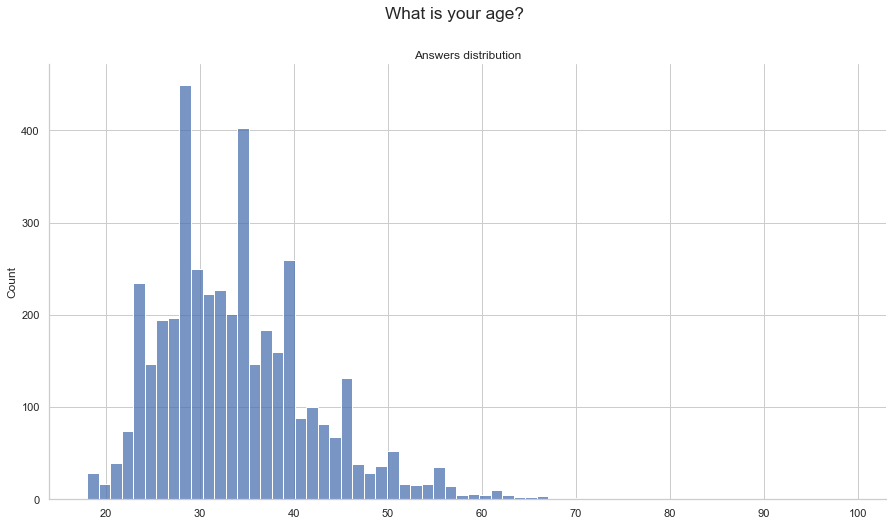

In [36]:
presenter.plot_answers_histogram(1)

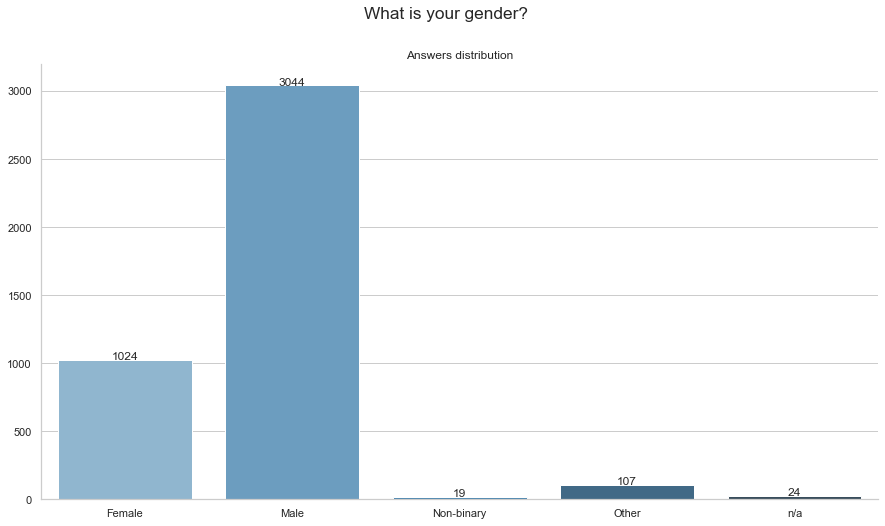

In [55]:
presenter.plot_answers_distribution(2)

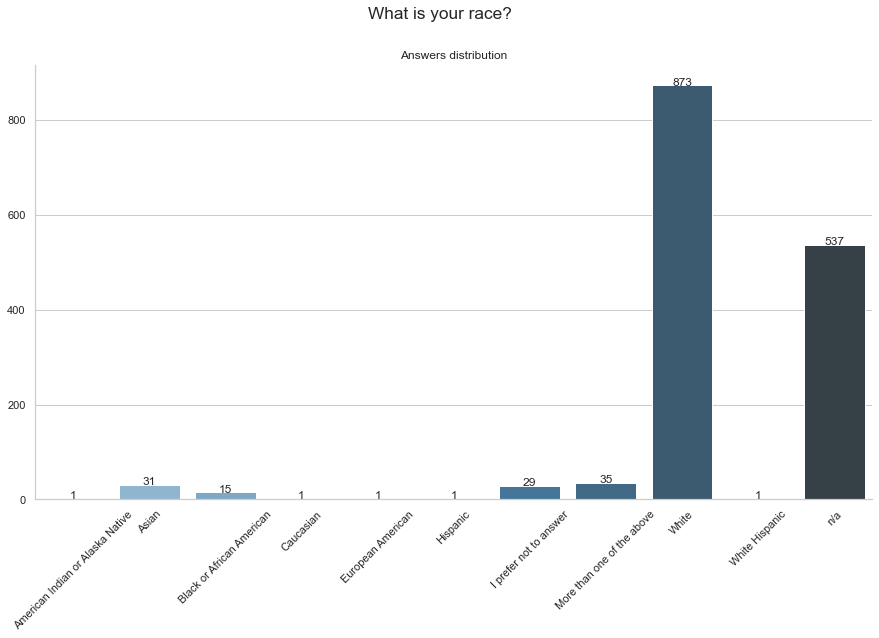

In [124]:
presenter.plot_answers_distribution(89)

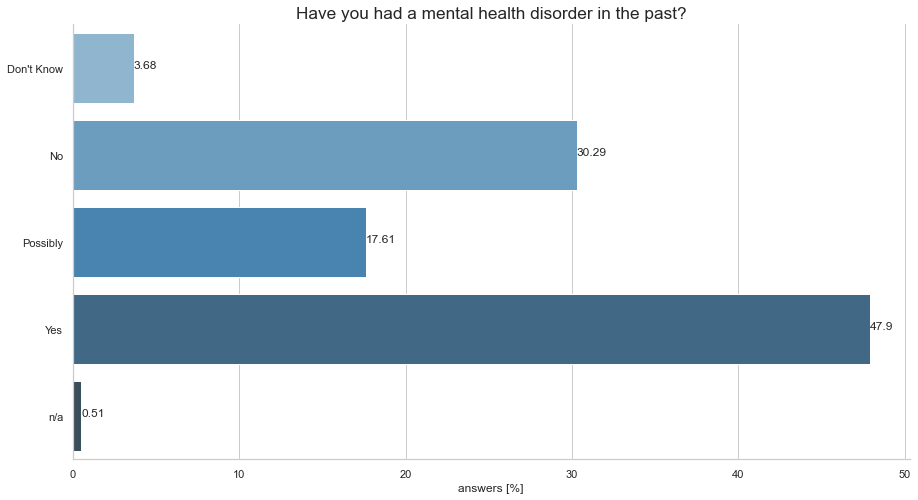

In [121]:
presenter.plot_answers_pct(32)

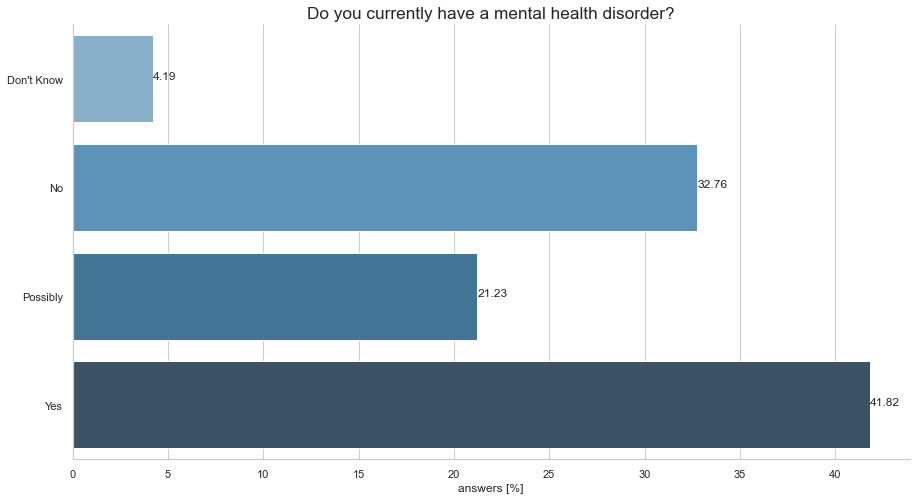

In [122]:
presenter.plot_answers_pct(33)

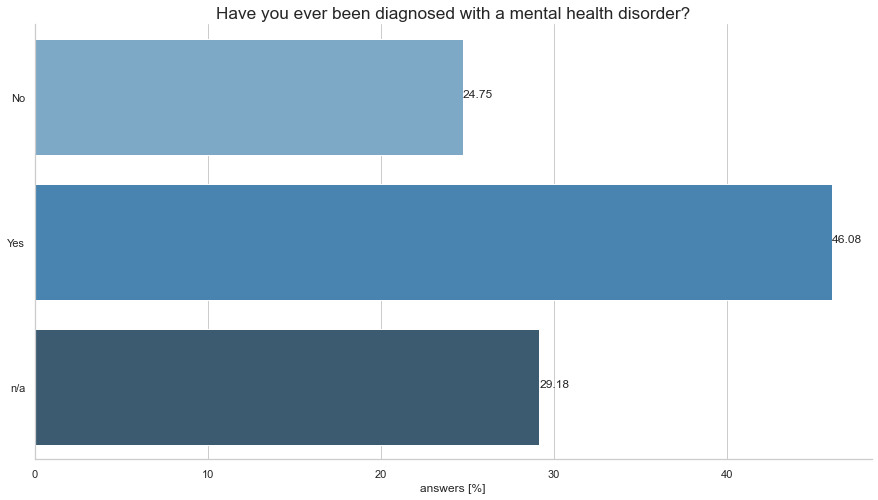

In [123]:
presenter.plot_answers_pct(34)

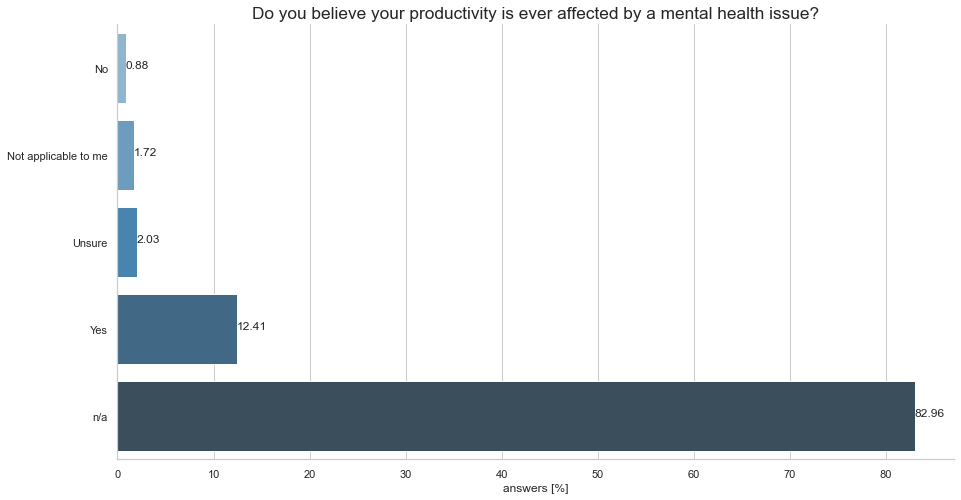

In [11]:
presenter.plot_answers_pct(54)

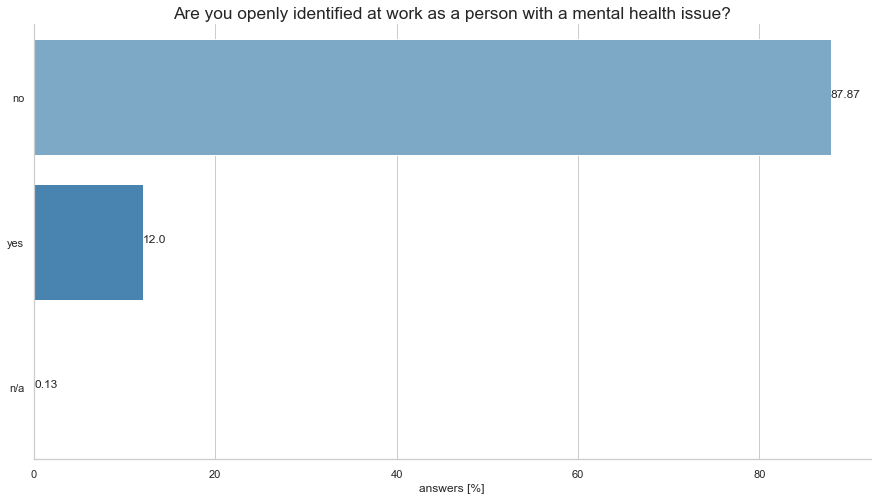

In [125]:
presenter.plot_answers_pct(78)

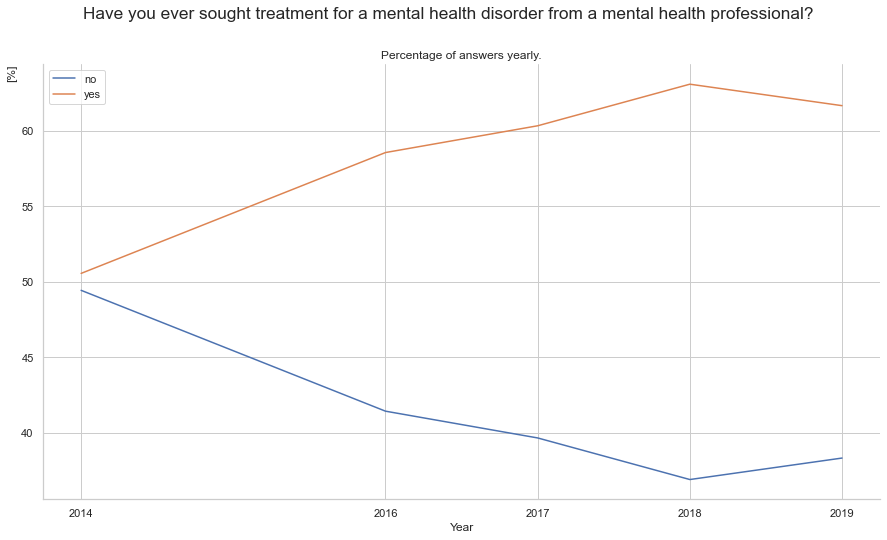

In [120]:
presenter.plot_answers_pct_yearly(7)

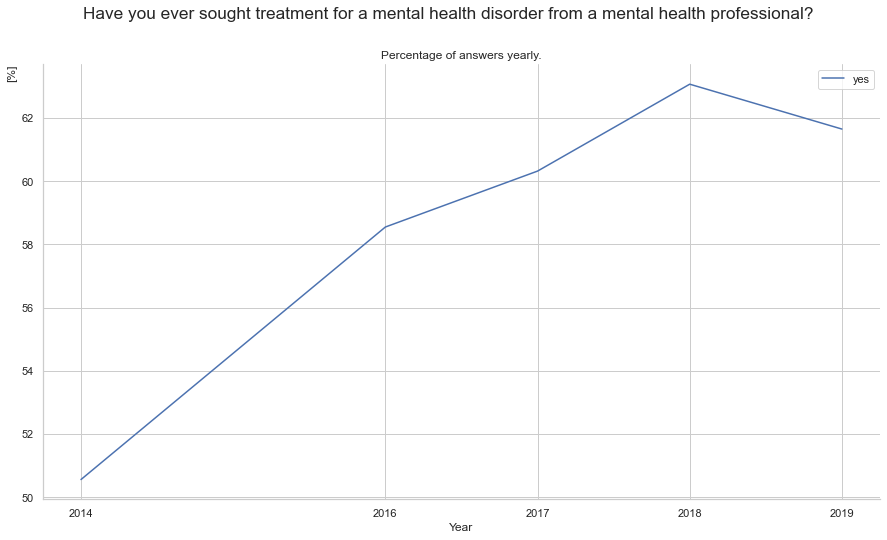

In [119]:
presenter.plot_answers_pct_yearly(7, True) # yes only

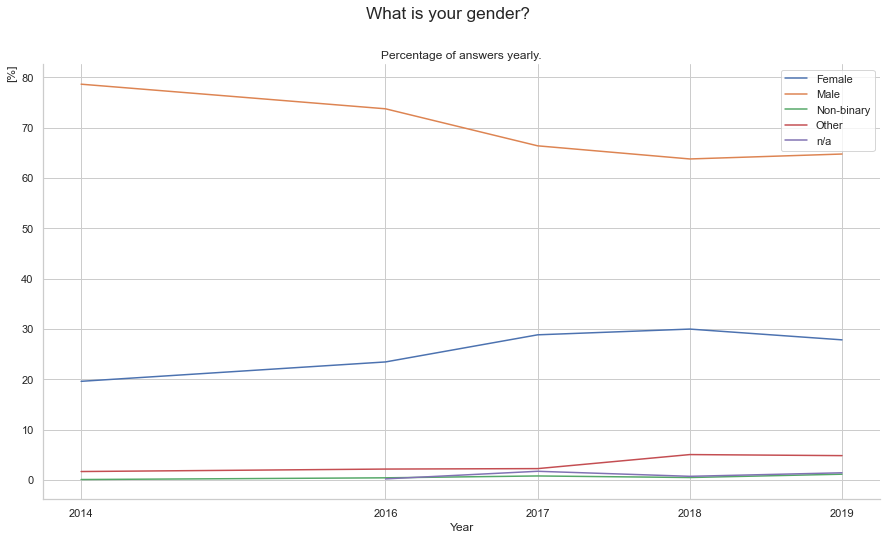

In [118]:
presenter.plot_answers_pct_yearly(2)

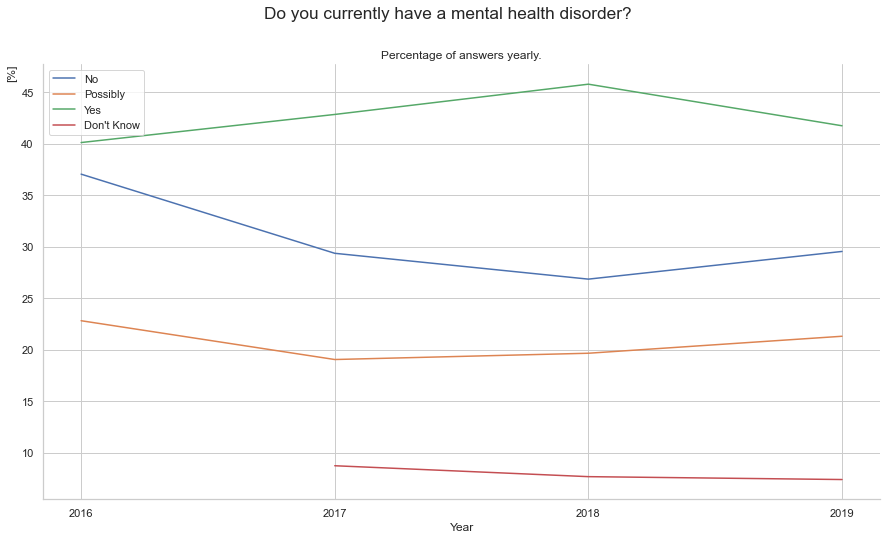

In [117]:
presenter.plot_answers_pct_yearly(33)

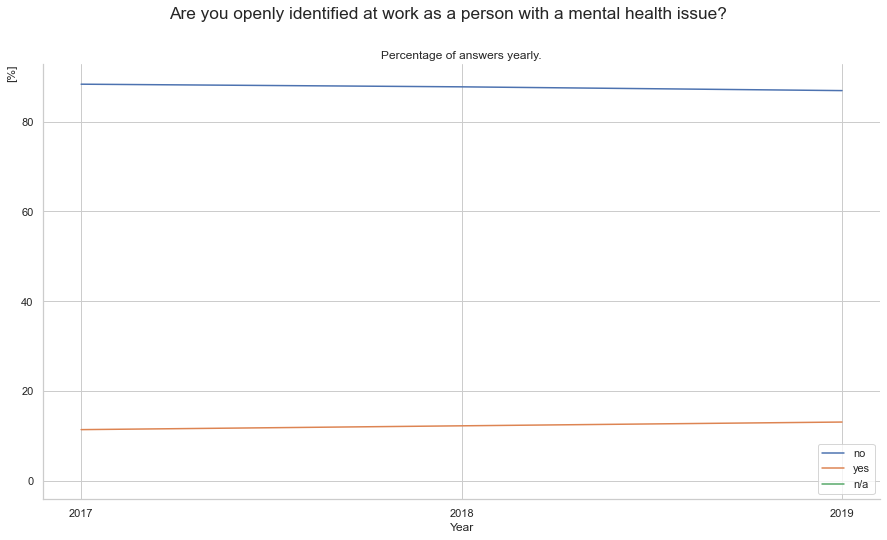

In [126]:
presenter.plot_answers_pct_yearly(78)

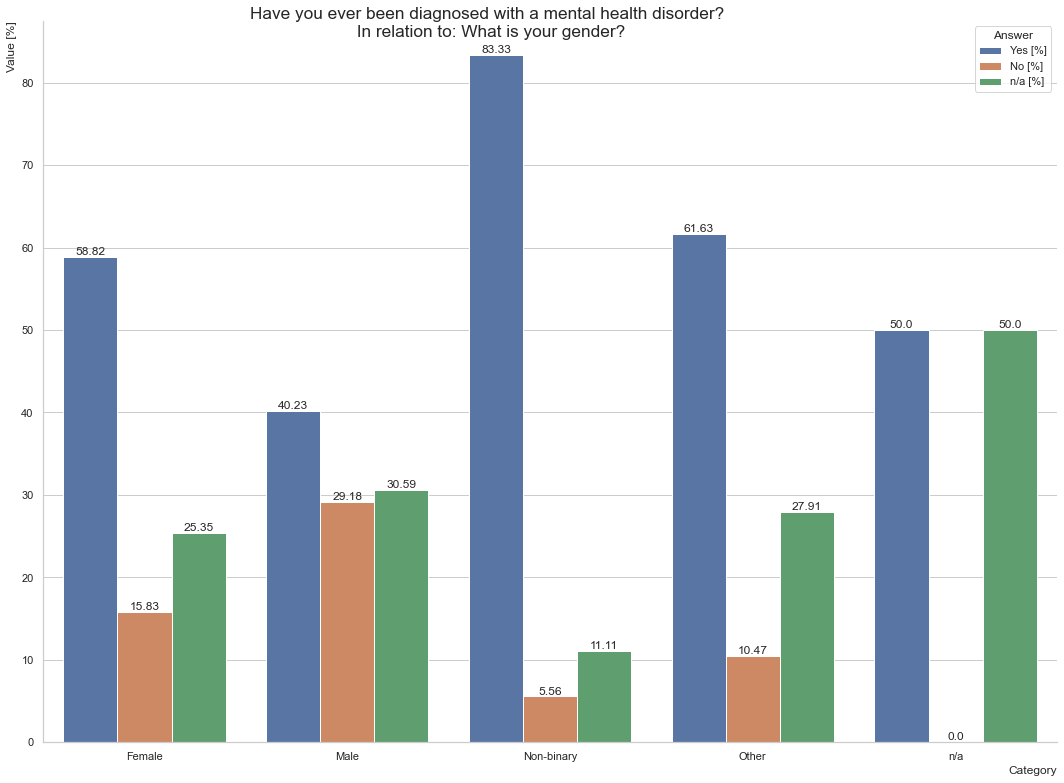

In [108]:
presenter.plot_answers_ratio_by_categories(2, 34)

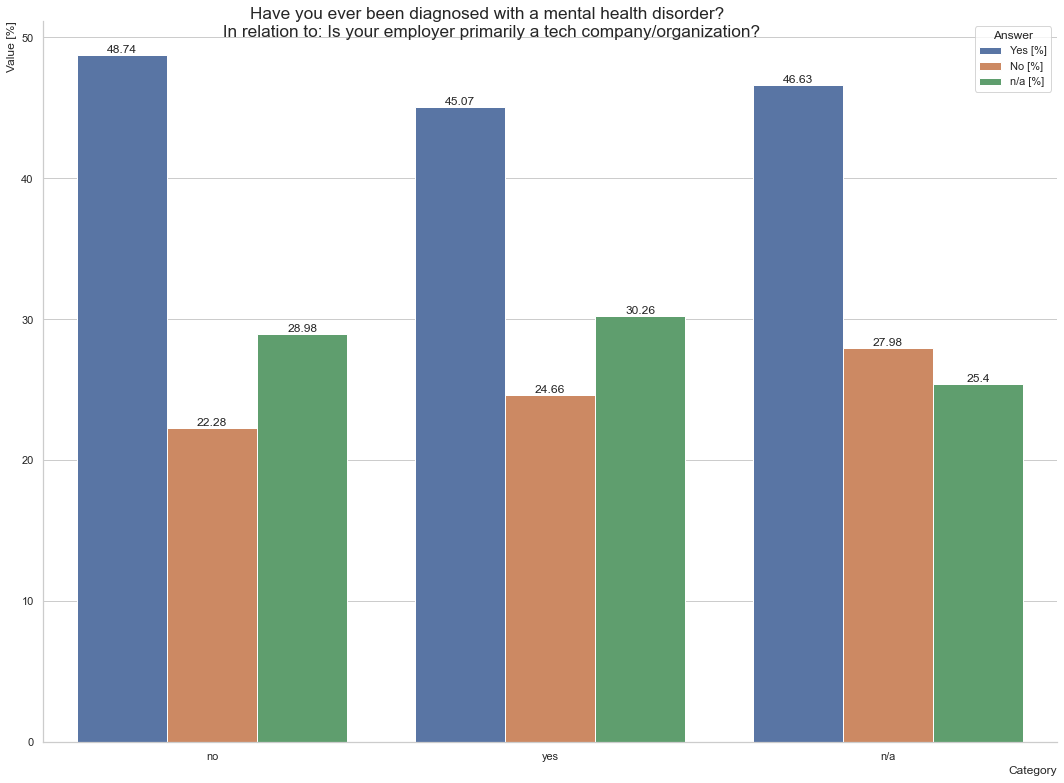

In [107]:
presenter.plot_answers_ratio_by_categories(9, 34)

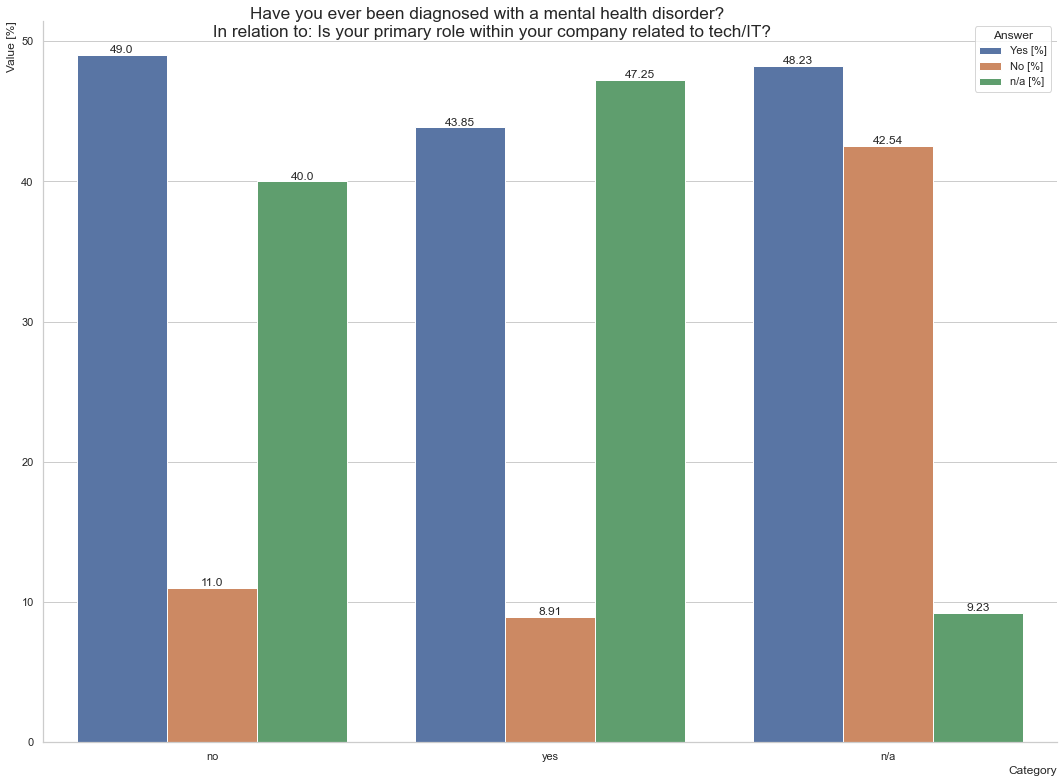

In [106]:
presenter.plot_answers_ratio_by_categories(13, 34)

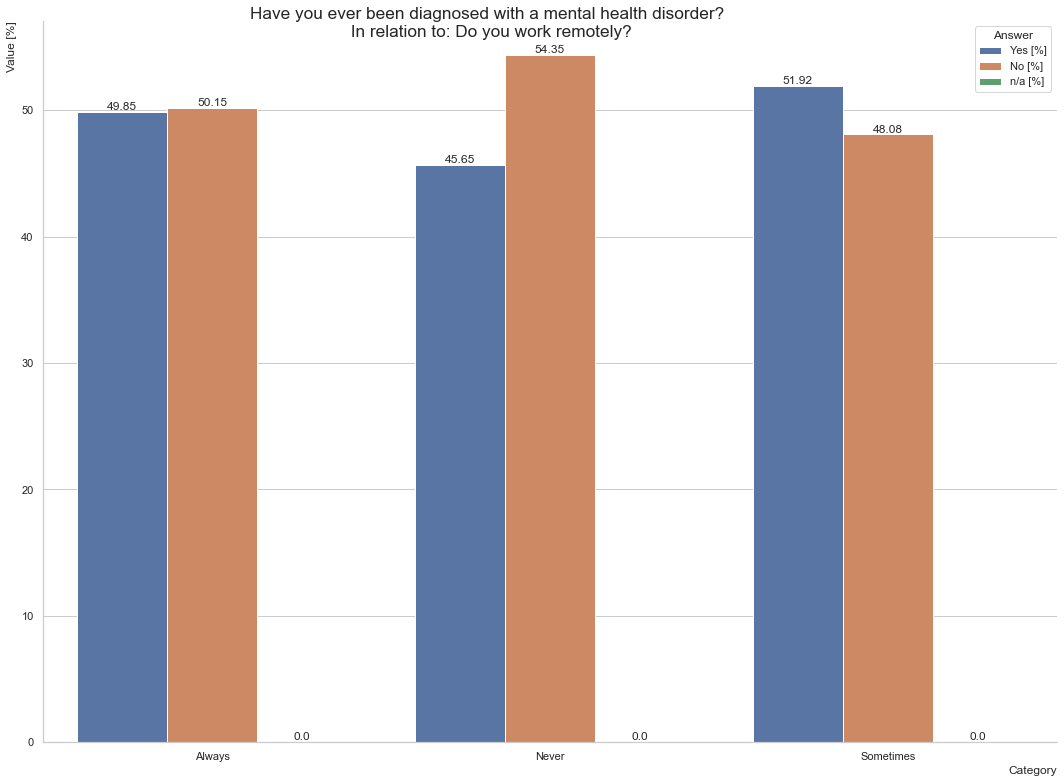

In [105]:
presenter.plot_answers_ratio_by_categories(118, 34)

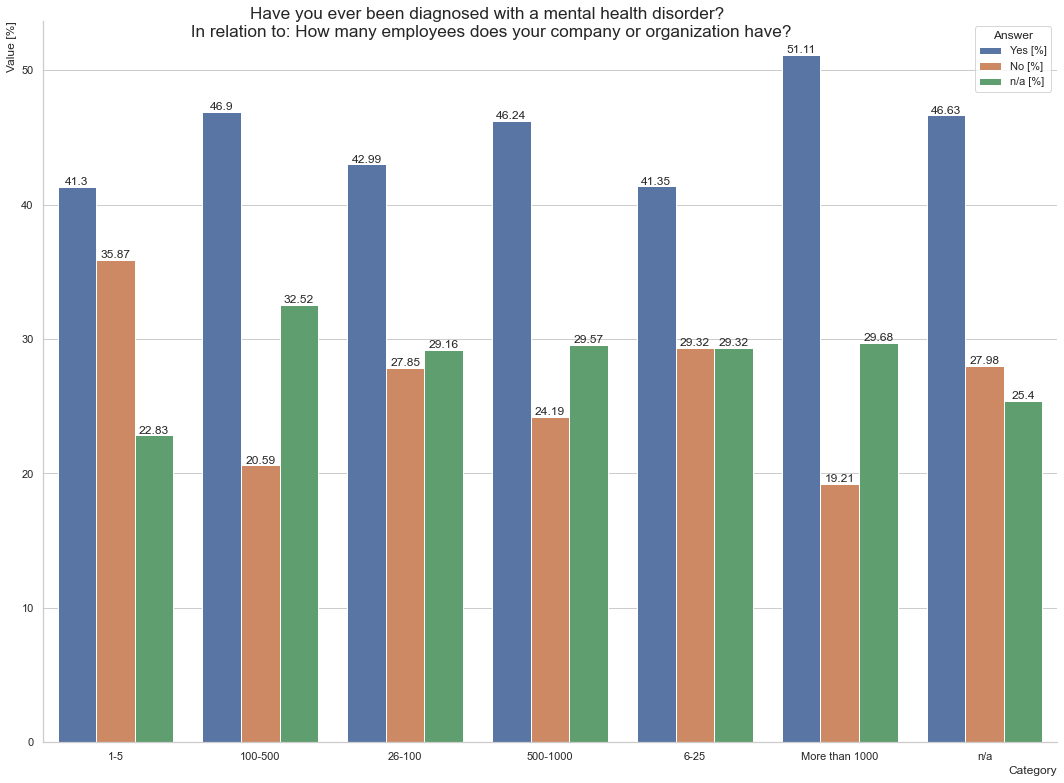

In [109]:
presenter.plot_answers_ratio_by_categories(8, 34)